<a href="https://colab.research.google.com/github/linhoangce/ml_with_pytorch_and_scikitlearn/blob/main/chapter15_pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project two - character-level language modeling in PyTorch

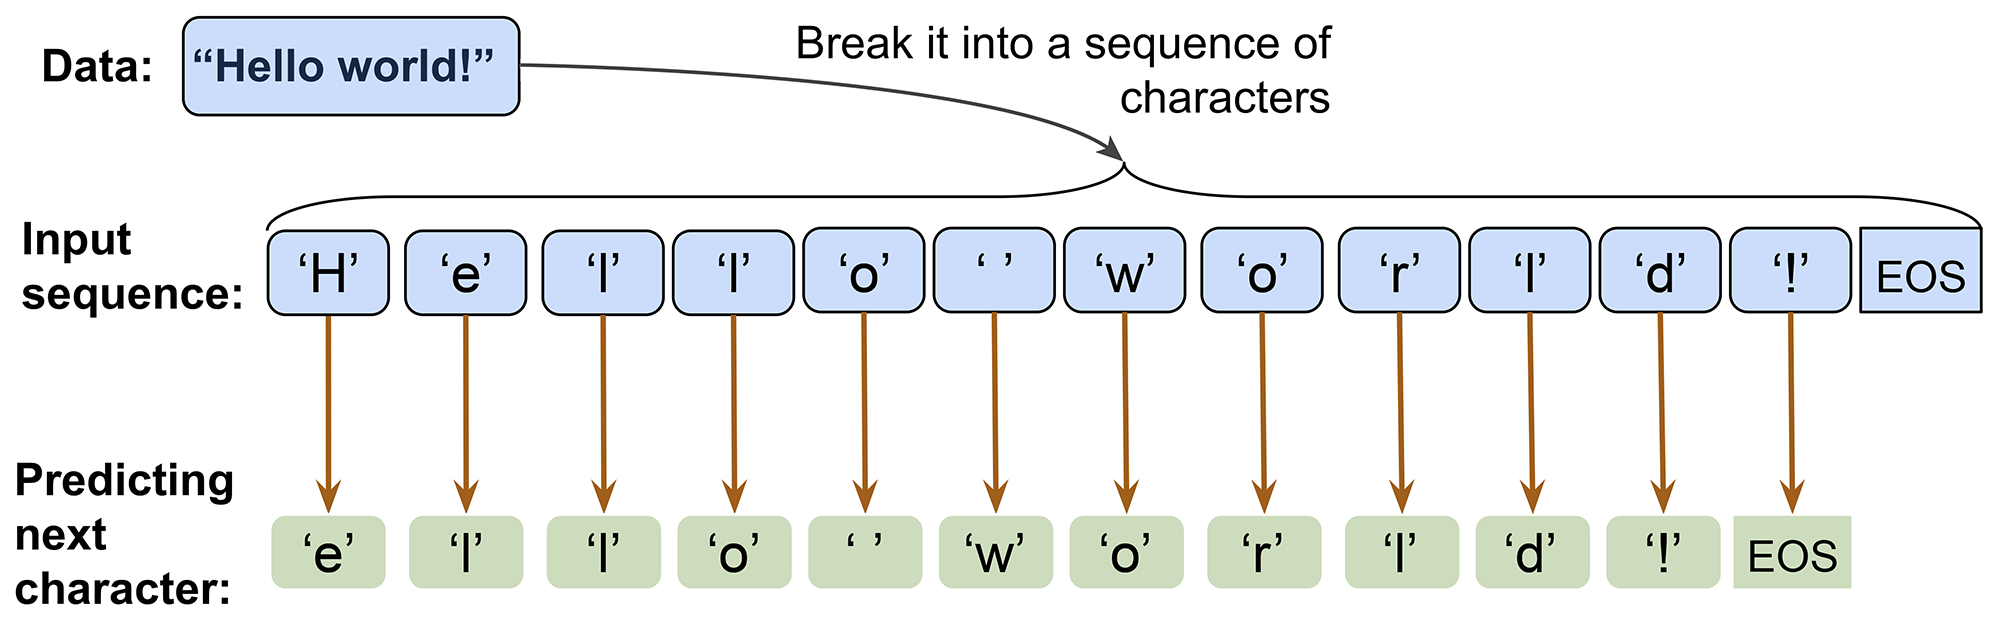

In [30]:
from IPython.display import Image

Image('https://raw.githubusercontent.com/rasbt/machine-learning-book/refs/heads/main/ch15/figures/15_11.png')

## Preprocessing the dataset

In [31]:
!curl -O https://www.gutenberg.org/files/1268/1268-0.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1124k  100 1124k    0     0   414k      0  0:00:02  0:00:02 --:--:--  414k


In [32]:
# read text directly from downloaded file
# remove portions from beginning and end
# represents set of unique characters with `char_Set`
import numpy as np

## reading and processing text
with open('1268-0.txt', 'r', encoding='utf-8') as fp:
  text = fp.read()

start_idx = text.find('THE MYSTERIOUS ISLAND')
end_idx = text.find('End of the Project Gutenberg')
text = text[start_idx:end_idx]
char_set = set(text)
print('Total length:', len(text))
print(f'Unique characters: {len(char_set)}')

Total length: 1112310
Unique characters: 80


Most NN libraries and RNN implementaions cannot deal with input data in string format, which is why we have to convert the text into a numeric format. To do this, we will create a simple Python dictionary that maps each character to an integer, `char2int`. We will also need to reverse mapping to convert the results of our model back to text using Numpy array for efficiency.

In [33]:
text

'THE MYSTERIOUS ISLAND\n\nby Jules Verne\n\n1874\n\n\n\n\nPART 1--DROPPED FROM THE CLOUDS\n\n\n\nChapter 1\n\n“Are we rising again?” “No. On the contrary.” “Are we descending?”\n “Worse than that, captain! we are falling!” “For Heaven’s sake heave out\nthe ballast!” “There! the last sack is empty!” “Does the balloon rise?”\n “No!” “I hear a noise like the dashing of waves. The sea is below the\ncar! It cannot be more than 500 feet from us!” “Overboard with every\nweight! ... everything!”\n\nSuch were the loud and startling words which resounded through the air,\nabove the vast watery desert of the Pacific, about four o’clock in the\nevening of the 23rd of March, 1865.\n\nFew can possibly have forgotten the terrible storm from the northeast,\nin the middle of the equinox of that year. The tempest raged without\nintermission from the 18th to the 26th of March. Its ravages were\nterrible in America, Europe, and Asia, covering a distance of eighteen\nhundred miles, and extending obliquely 

In [34]:
char_set

{'\n',
 ' ',
 '!',
 '&',
 '(',
 ')',
 '*',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '=',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '‘',
 '’',
 '“',
 '”'}

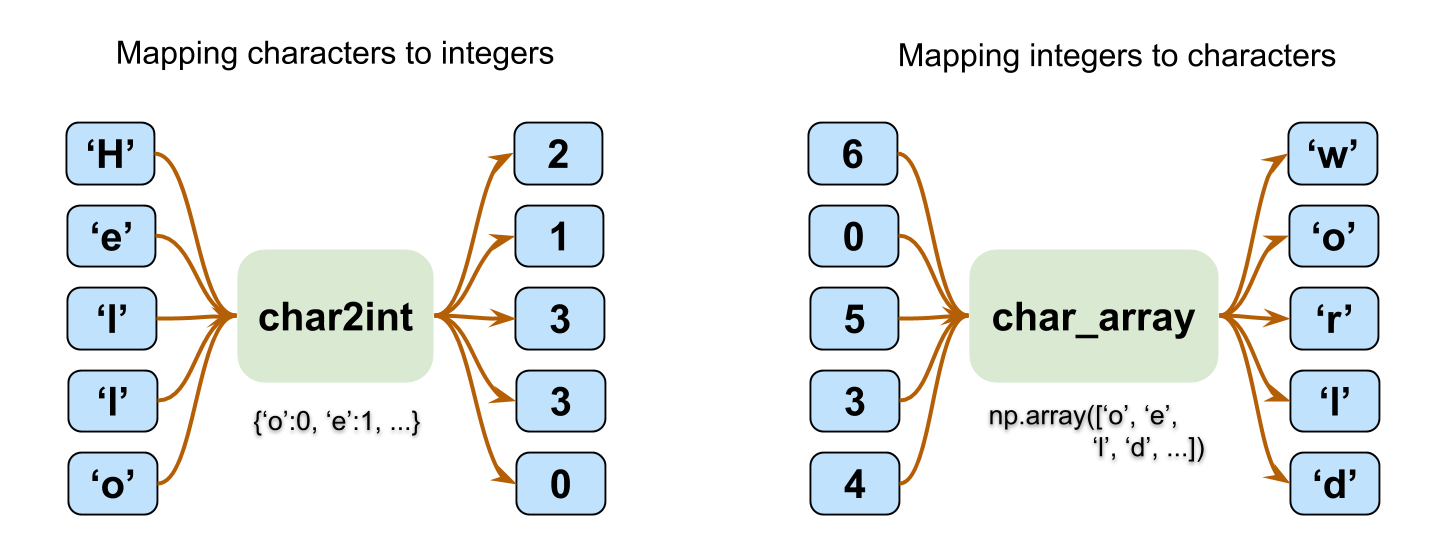

In [35]:
Image('https://raw.githubusercontent.com/rasbt/machine-learning-book/refs/heads/main/ch15/figures/15_12.png')

In [36]:
# build a dict to map character to integers
# and reverse mapping via indexing a NumPY array
chars_sorted = sorted(char_set)

char2int = {ch:i for i, ch in enumerate(chars_sorted)}

char_array = np.array(chars_sorted)

text_encoded = np.array(
    [char2int[ch] for ch in text],
    dtype=np.int32
)
print(f'Text encoded shape: {text_encoded.shape}')
print(text[:15], '== Encoded ==>', text_encoded[:15])
print(text_encoded[15:21], '== Reverse ==>',
      ''.join(char_array[text_encoded[15:21]]))

Text encoded shape: (1112310,)
THE MYSTERIOUS  == Encoded ==> [44 32 29  1 37 48 43 44 29 42 33 39 45 43  1]
[33 43 36 25 38 28] == Reverse ==> ISLAND


In [37]:
# print out mappings of first five characters
for ex in text_encoded[:5]:
  print(f'{ex} -> {char_array[ex]}')

44 -> T
32 -> H
29 -> E
1 ->  
37 -> M


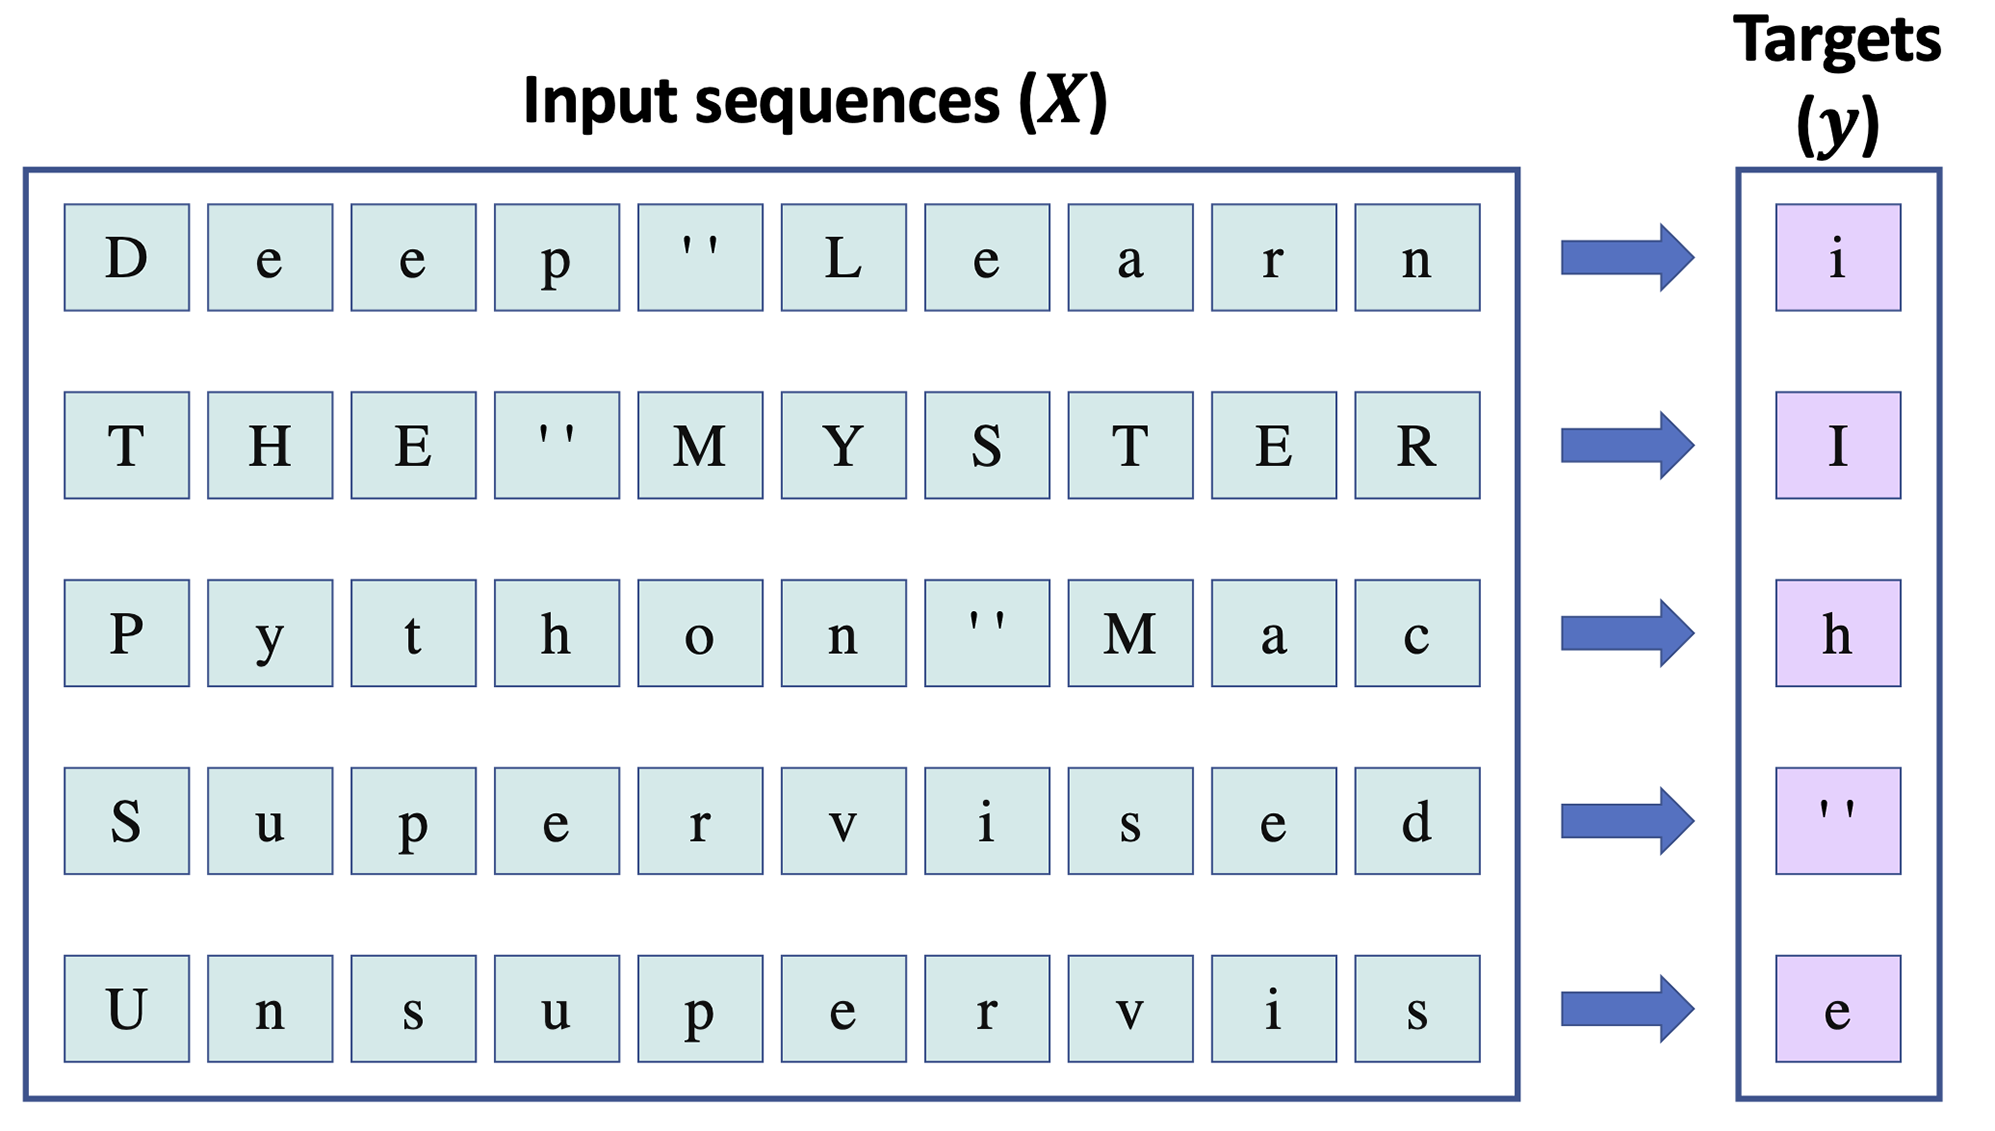

In [38]:
Image('https://raw.githubusercontent.com/rasbt/machine-learning-book/refs/heads/main/ch15/figures/15_13.png')

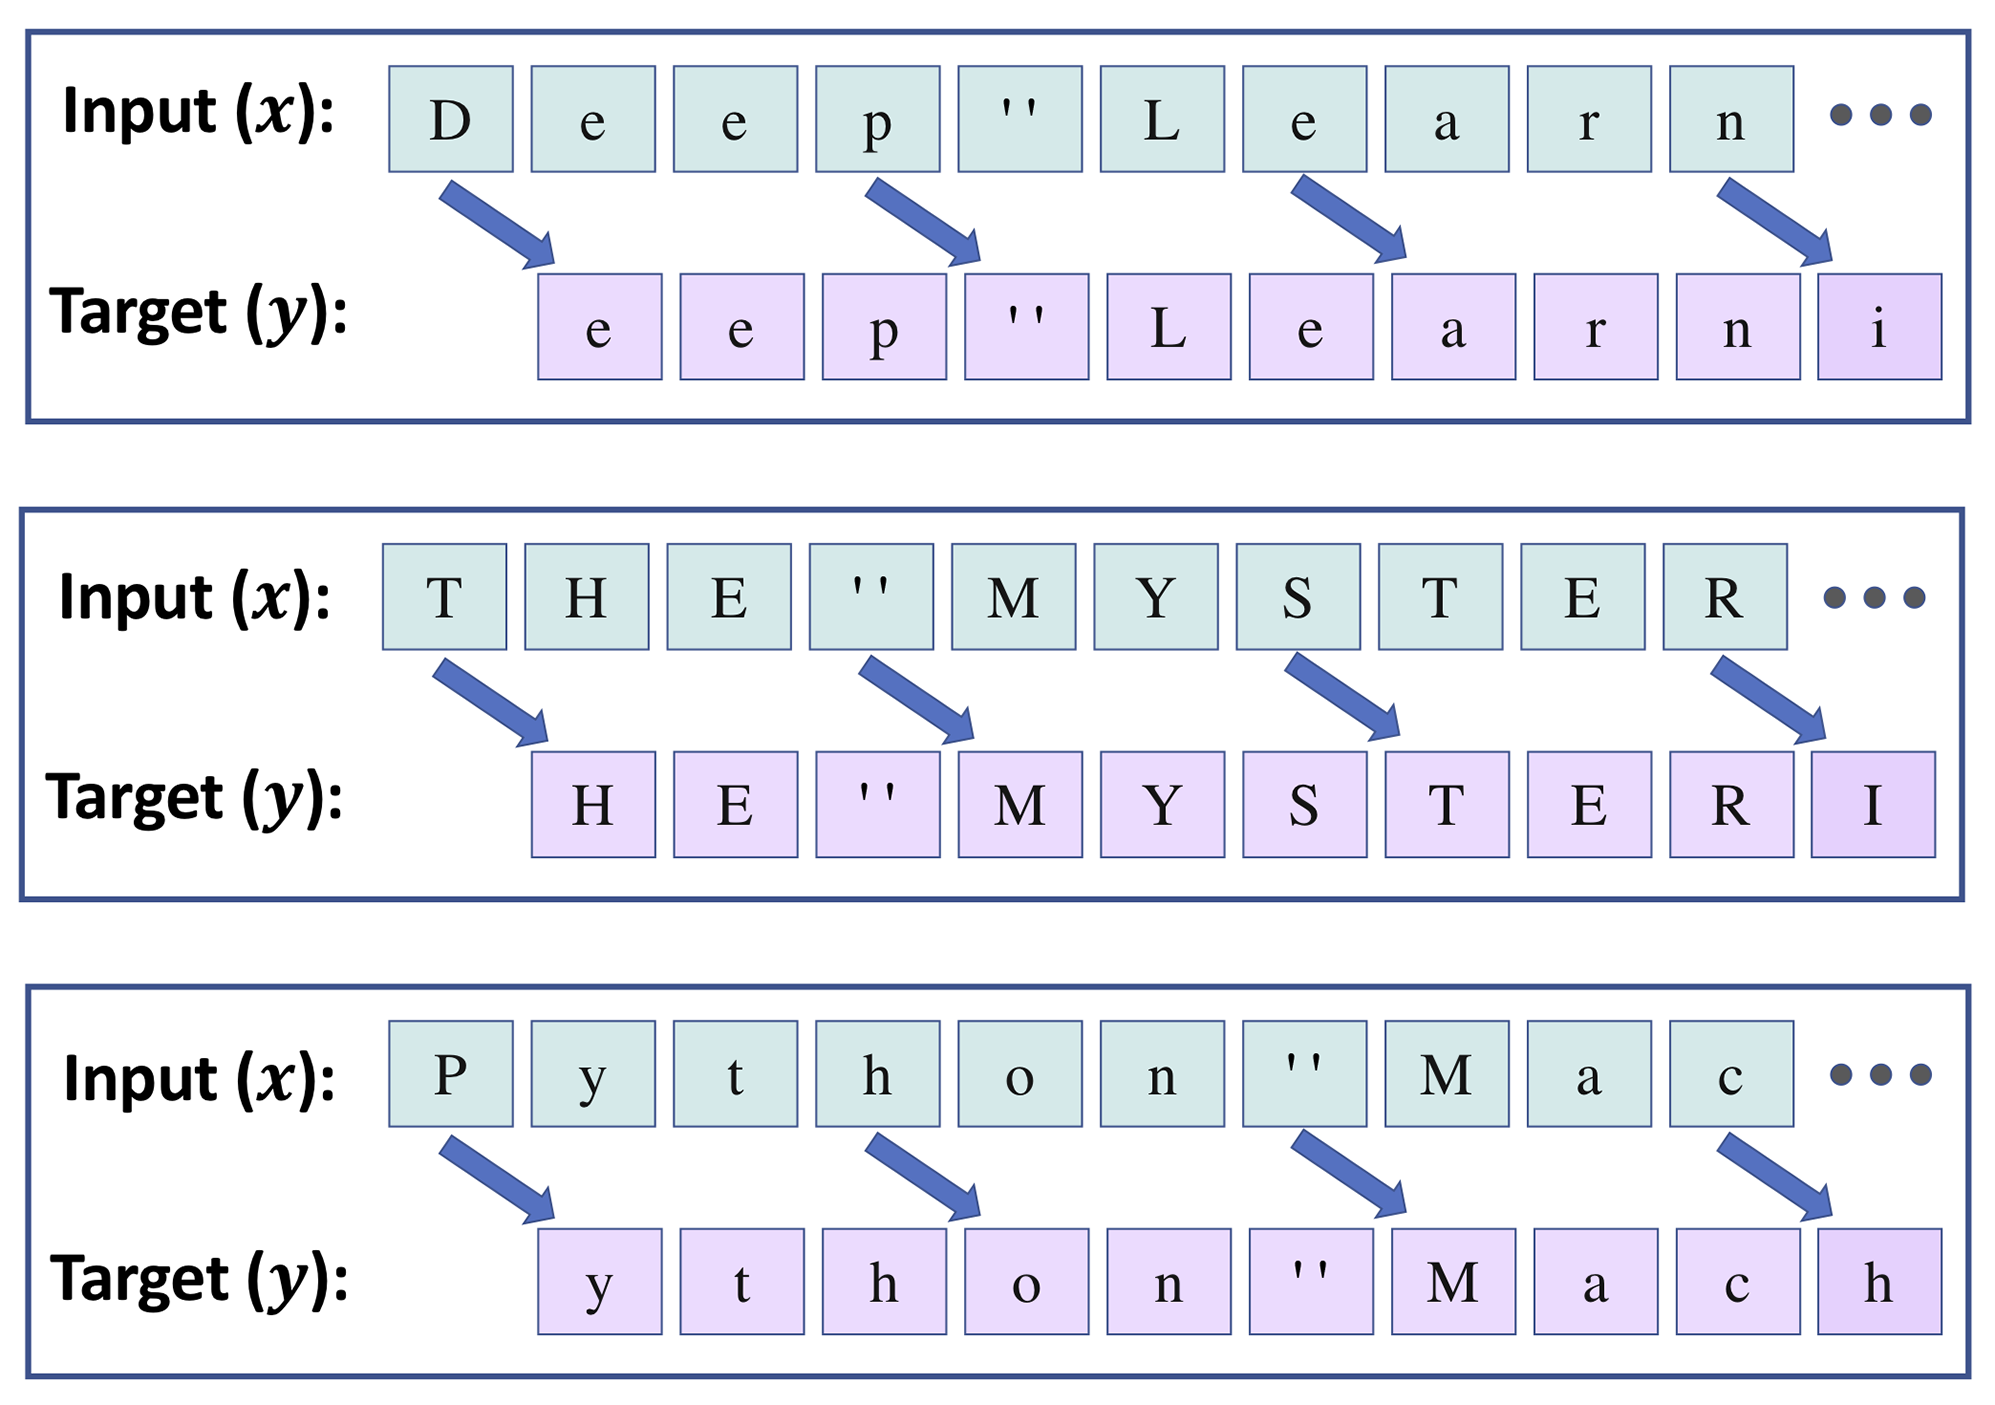

In [39]:
Image('https://raw.githubusercontent.com/rasbt/machine-learning-book/refs/heads/main/ch15/figures/15_14.png')

To implement the text generation task in PyTorch, let's first clip the sequence length to 40. This means that the input tensor, $x$, consists of 40 tokens. In practice, the sequence length impacts the quality of the generated text. Longer sequences an result in more meaningful sentences. For shorter sequences, however, the model might focus on capturing individual words correctly, while ignoring the context for the most part. Although longer sequences usually result in more meaningful sentences, for long sequences, the RNN model will have probelsm capturing long-range dependencies. Thus, in practice, finding a sweet spot and good value for the sequence length is a hyperparameter optimization problem, which we have to evaluate emperically.

From the figure, the inputs, $x$, and targets, $y$, are offset by one character. Hence we will split the text into chunks of size 41: the first 40 characters will form the input sequence, $x$, and the last 40 elements will form the target sequence, $y$.

We have already stored the entire encoded text in its original order in `text_encoded`. We will first create text chunk consisting of 41 characters each. We will further get rid of the last chunk if it is shorter than 41 characters. As a result, the new chunked dataset, named `text_chunks`, will always contain sequences of size 41. The 41-character chunks will then be used to construct the sequence $x$ as well as the sequences $y$, both of which will have 40 elements. For instance, sequence $x$ will consist of elements with indices $[0,1, \dots, 39]$, while sequences $y$ will be shifted by one position with respect to $x$, its corresponding indices will be $[1, 2, \dots, 40]$.

In [40]:
import torch
from torch.utils.data import Dataset

seq_length = 40
chunk_size = seq_length + 1

text_chunks = [text_encoded[i:i+chunk_size]
               for i in range(len(text_encoded)-chunk_size)]

text_chunks[:5], text_chunks[0].shape

([array([44, 32, 29,  1, 37, 48, 43, 44, 29, 42, 33, 39, 45, 43,  1, 33, 43,
         36, 25, 38, 28,  0,  0, 51, 74,  1, 34, 70, 61, 54, 68,  1, 46, 54,
         67, 63, 54,  0,  0, 12, 19], dtype=int32),
  array([32, 29,  1, 37, 48, 43, 44, 29, 42, 33, 39, 45, 43,  1, 33, 43, 36,
         25, 38, 28,  0,  0, 51, 74,  1, 34, 70, 61, 54, 68,  1, 46, 54, 67,
         63, 54,  0,  0, 12, 19, 18], dtype=int32),
  array([29,  1, 37, 48, 43, 44, 29, 42, 33, 39, 45, 43,  1, 33, 43, 36, 25,
         38, 28,  0,  0, 51, 74,  1, 34, 70, 61, 54, 68,  1, 46, 54, 67, 63,
         54,  0,  0, 12, 19, 18, 15], dtype=int32),
  array([ 1, 37, 48, 43, 44, 29, 42, 33, 39, 45, 43,  1, 33, 43, 36, 25, 38,
         28,  0,  0, 51, 74,  1, 34, 70, 61, 54, 68,  1, 46, 54, 67, 63, 54,
          0,  0, 12, 19, 18, 15,  0], dtype=int32),
  array([37, 48, 43, 44, 29, 42, 33, 39, 45, 43,  1, 33, 43, 36, 25, 38, 28,
          0,  0, 51, 74,  1, 34, 70, 61, 54, 68,  1, 46, 54, 67, 63, 54,  0,
          0, 12, 19, 1

In [41]:
len(text_chunks)

1112269

In [42]:
class TextDataset(Dataset):
  def __init__(self, text_chunks):
    self.text_chunks = text_chunks

  def __len__(self):
    return len(self.text_chunks)

  def __getitem__(self, idx):
    text_chunk = self.text_chunks[idx]
    return text_chunk[:-1].long(), text_chunk[1:].long()

seq_dataset = TextDataset(torch.tensor(np.array(text_chunks)))

In [43]:
seq_dataset[0]

(tensor([44, 32, 29,  1, 37, 48, 43, 44, 29, 42, 33, 39, 45, 43,  1, 33, 43, 36,
         25, 38, 28,  0,  0, 51, 74,  1, 34, 70, 61, 54, 68,  1, 46, 54, 67, 63,
         54,  0,  0, 12]),
 tensor([32, 29,  1, 37, 48, 43, 44, 29, 42, 33, 39, 45, 43,  1, 33, 43, 36, 25,
         38, 28,  0,  0, 51, 74,  1, 34, 70, 61, 54, 68,  1, 46, 54, 67, 63, 54,
          0,  0, 12, 19]))

In [44]:
text_chunks[0], text_chunks[0][:-1], text_chunks[0][1:]

(array([44, 32, 29,  1, 37, 48, 43, 44, 29, 42, 33, 39, 45, 43,  1, 33, 43,
        36, 25, 38, 28,  0,  0, 51, 74,  1, 34, 70, 61, 54, 68,  1, 46, 54,
        67, 63, 54,  0,  0, 12, 19], dtype=int32),
 array([44, 32, 29,  1, 37, 48, 43, 44, 29, 42, 33, 39, 45, 43,  1, 33, 43,
        36, 25, 38, 28,  0,  0, 51, 74,  1, 34, 70, 61, 54, 68,  1, 46, 54,
        67, 63, 54,  0,  0, 12], dtype=int32),
 array([32, 29,  1, 37, 48, 43, 44, 29, 42, 33, 39, 45, 43,  1, 33, 43, 36,
        25, 38, 28,  0,  0, 51, 74,  1, 34, 70, 61, 54, 68,  1, 46, 54, 67,
        63, 54,  0,  0, 12, 19], dtype=int32))

In [45]:
# take a look at some example sequences from transformed dataset
for i, (seq, target) in enumerate(seq_dataset):
  print(' Input (x):', repr(''.join(char_array[seq])))
  print('Target (y):', repr(''.join(char_array[target])))
  print()
  if i == 2:
    break

 Input (x): 'THE MYSTERIOUS ISLAND\n\nby Jules Verne\n\n1'
Target (y): 'HE MYSTERIOUS ISLAND\n\nby Jules Verne\n\n18'

 Input (x): 'HE MYSTERIOUS ISLAND\n\nby Jules Verne\n\n18'
Target (y): 'E MYSTERIOUS ISLAND\n\nby Jules Verne\n\n187'

 Input (x): 'E MYSTERIOUS ISLAND\n\nby Jules Verne\n\n187'
Target (y): ' MYSTERIOUS ISLAND\n\nby Jules Verne\n\n1874'



In [46]:
# transform dataste into mini batches
from torch.utils.data import DataLoader

batch_size = 64

torch.manual_seed(1)

seq_dl = DataLoader(seq_dataset, batch_size=batch_size,
                    shuffle=True, drop_last=True)

## Building a character level RNN model

In [47]:
from torch import nn

class RNN(nn.Module):
  def __init__(self, vocab_size, embed_dim, rnn_hidden_size):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim)
    self.rnn_hidden_size = rnn_hidden_size
    self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, batch_first=True)
    self.fc = nn.Linear(rnn_hidden_size, vocab_size)

  def forward(self, x, hidden, cell):
    out = self.embedding(x).unsqueeze(1)
    out, (hidden, cell) = self.rnn(out, (hidden, cell))
    out = self.fc(out).reshape(out.size(0), -1) # -1 is to flatten rest of dimensions
    return out, hidden, cell

  def init_hidden(self, batch_size):
    hidden = torch.zeros(1, batch_size, self.rnn_hidden_size)
    cell = torch.zeros(1, batch_size, self.rnn_hidden_size)
    return hidden, cell


We will need to have the logits as outputs of the model so that we can sample from the model predictions in order to generate new text.

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [51]:
vocab_size = len(char_array)
embed_dim = 256
rnn_hidden_size = 512

torch.manual_seed(1)

model = RNN(vocab_size, embed_dim, rnn_hidden_size)
model.to(device)
model

RNN(
  (embedding): Embedding(80, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=80, bias=True)
)

In [53]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.005)

epochs = 10000
torch.manual_seed(1)

for epoch in range(epochs):
  hidden, cell = model.init_hidden(batch_size)
  hidden, cell = hidden.to(device), cell.to(device)
  seq_batch, target_batch = next(iter(seq_dl))
  seq_bacth = seq_batch.to(device)
  target_batch = target_batch.to(device)
  optimizer.zero_grad()
  loss = 0

  for c in range(seq_length):
    pred, hidden, cell = model(seq_batch[:, c].to(device), hidden, cell)
    loss += loss_fn(pred, target_batch[:, c])

  loss.backward()
  optimizer.step()
  loss = loss.item() / seq_length

  if epoch % 500 == 0:
    print(f'Epoch {epoch} | Loss: {loss:.4f}')

Epoch 0 | Loss: 4.3720
Epoch 500 | Loss: 1.4102
Epoch 1000 | Loss: 1.3139
Epoch 1500 | Loss: 1.3023
Epoch 2000 | Loss: 1.2362
Epoch 2500 | Loss: 1.1805
Epoch 3000 | Loss: 1.1492
Epoch 3500 | Loss: 1.1740
Epoch 4000 | Loss: 1.1265
Epoch 4500 | Loss: 1.1378
Epoch 5000 | Loss: 1.1264
Epoch 5500 | Loss: 1.1237
Epoch 6000 | Loss: 1.1274
Epoch 6500 | Loss: 1.1711
Epoch 7000 | Loss: 1.1056
Epoch 7500 | Loss: 1.1232
Epoch 8000 | Loss: 1.1267
Epoch 8500 | Loss: 1.1777
Epoch 9000 | Loss: 1.1359
Epoch 9500 | Loss: 1.1629


## Evaluation phase - generating new text passages

The RNN model we trained in the previous section returns the logits of size 80 for each uique character. These logits can be readily converted to probabilities, via the softmax function, that a particular character will be encounterd as the next character. To predict the next cahracter in the sequence, we can simply select the element with the maximum logit value, which is equivalent to selecting the character with the highest posibility. However, instead of always selecting the character with the highest likelihood, we want to (randomly) *sample* from the outputs; otherwise, the model will always product the same text.

PyTorch provides a class, `torch.distributions.categorical.Categorical`, which we can use to draw random samples from a categorical distribution.

In [54]:
from torch.distributions.categorical import Categorical

torch.manual_seed(1)

logits = torch.tensor([[1.0, 1.0, 1.0]])

print(f'Probabilities: {nn.functional.softmax(logits, dim=1).numpy()[0]}')

m = Categorical(logits=logits)
samples = m.sample((10,))

print(samples.numpy())

Probabilities: [0.33333334 0.33333334 0.33333334]
[[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [2]
 [1]
 [1]]


In [55]:
# more occurences of higher probability for an index
torch.manual_seed(1)

logits = torch.tensor([[1.0, 1.0, 3.0]])

print(f'Probs: {nn.functional.softmax(logits, dim=1).numpy()}')

m = Categorical(logits=logits)
samples = m.sample((10,))
print(samples.numpy())

Probs: [[0.10650698 0.10650698 0.78698605]]
[[0]
 [2]
 [2]
 [1]
 [2]
 [1]
 [2]
 [2]
 [2]
 [2]]


We will define a function, `sample()`, that receives a short starting string, `starting_str`, and generate a new string, `generated_str`, which is initially set to the input string. `starting_str` is encoded to a sequence of integers, `encoded_input`. `encoded_input` is passed to the RNN model one character at a time to update the hidden states. The last character of `encoded_input` is passed to the model to generate a new character. The output of the RNN model represents the logits (a vector of size 80, the total number of possible characters) for the next character after observing the input sequence by the model.

Here, we only use the `logits` output (that is, $o^{(t)}$), which is passed to the `Categorical` class to generate a new sample. This new sample is converted to a character, which is then appended to the end of the generated string, `generated_text`, increasing its length by `. Then, this process if repeated until the length of the generated string reaches the desired value. The process of consuming the generated sequence as input for generating new elements is called **autoregression**.

In [86]:
def sample(model, starting_str,
           len_generated_text=500,
           scaled_factor=1.0):
  encoded_input = torch.tensor(
      [char2int[s] for s in starting_str]
  )
  encoded_input = torch.reshape(encoded_input,
                                (1, -1))
  generated_str = starting_str

  model.eval()
  hidden, cell = model.init_hidden(1)
  hidden, cell = hidden.to(device), cell.to(device)

  for c in range(len(starting_str) - 1):
    _, hidden, cell = model(encoded_input[:, c].view(1).to(device),
                            hidden, cell)
    last_char = encoded_input[:, -1]

    for i in range(len_generated_text):
      logits, hidden, cell = model(last_char.view(1).to(device),
                                   hidden, cell)
      logits = torch.squeeze(logits, 0)
      scaled_logits = logits * scaled_factor
      m = Categorical(logits=scaled_logits)
      last_char = m.sample()
      generated_str += str(char_array[last_char])

  return generated_str


In [87]:
torch.manual_seed(1)

print(sample(model, starting_str='The island'))

The islandable Sun’t day we have resumed this want
occupied there? But heless, in the fourth bitt, climbing, and
dangerous good manifestize bulled in Granite House, and the pine of this part of water. Followed them with borden cause. He stopped will a
great Bops of her riggace, which would ne!” said Claw can knive aid did for the sea, my return in the night, intentioned.

They have performed a moment and either the way lighted that there are about, when now, in certain bork must place so unconsumed into toke of a mile in all the shore, which could one
sort, Herbert was only be, for his compectment, casueable distance which would not be supposed that the
ensignest of smile?”

“Well, abavancy,” said Harding. “you are as more inspecting! You perhus to uak
you have known a man. It was an engineer’s week and plufful very
covered by the height of the missurge again object was not a hole of the month of Wheiling period of their eyes. These
provinced themselves to the eleven, discovered beside

To control the predictability of the generated samples (that is, generating text following the learned patterns from the training text verses adding more randomness), the logits coputed by the RNN model can be scaled before being passed to `Categorical` for sampling. The scaling factor, $\alpha$, can be interpreted as an analog to the temperature in physics. Higher temperatures result in more entropy or randomness versus more predictable behavior at lower temperatures. By scaling the logits with $\alpha < 1$, the probabilities computed by the softmax function become more uniform.

In [79]:
logits = torch.tensor([[1.0, 1.0, 3.0]])
print('Probabilities before sca1ling: ',
        nn.functional.softmax(logits, dim=1).numpy()[0])
print('Probabilities after scaling with 0.5:',
      nn.functional.softmax(0.5 * logits, dim=1).numpy()[0])
print('Probabilities after scaling with 0.1:',
      nn.functional.softmax(0.1 * logits, dim=1).numpy()[0])

Probabilities before sca1ling:  [0.10650698 0.10650698 0.78698605]
Probabilities after scaling with 0.5: [0.21194156 0.21194156 0.57611686]
Probabilities after scaling with 0.1: [0.3104238  0.3104238  0.37915248]


In [80]:
# \alpha = 2.0 -> more predictable
torch.manual_seed(1)

sample(model, starting_str='The island', scaled_factor=2.0)


'The islandanion. About the 15th of March.\n\nThe first time we will be perhaps, but the four other fell back for the cart was already respect the wind, and they were not the bridge had been many dead.\n\n“And what is to be domed as a subterranean power in the evening to the interior of the sea went of the island, but already seen the sea, and the plan which must be a manner.\n\nThe sea was not the 20th of February, the 17th of March. They were actually seen beneath the waters of\nthe island, and the stream which in the opposite and the sea. The stranger would be made into the\nchannel, when they were as soon as a man would be seen to the shore.\n\n“What will be surprised the same point of the beach, and the engineer’s plan, which intended to the same time they made the engineer, “the strange flesh.\n\nThe wind was common wounded of the Mandible Cape, and in the meridian of the southern responted about the same time the dog had not been\nmore easily allowed the bridge and constructed t

In [81]:
torch.manual_seed(1)

sample(model, starting_str='The island', scaled_factor=0.5)

'The islandaborn, Abold tawered, recountent, “this amb-uark,\ntwerefu flavey, mixinglished.”\n\nThis fles convi, offerage wry Neaving! Mrnhirl, but till? Daylikne, disadvently, at Skurphe\n2sox,” resear.eyie\non.” Looced his numberascent, poor to-place hunt\nhalvestoped to esue that the\nBROPPE surre!-Fire; all wlanpk irodaid.\nLdge.\nHopful; Tomward, bolining to more intell.”\n\nThese, Hald wapen hin over Cyrusc,, perhauks suddenllves untevametati, doseablem, wxhesn,\nreink. I must thus\nplaces myriat fuise.”e fortunaeing,; a f8doci..a\nprools\nrivy,--fit to examp.e\nso diadopiness, 5\n? What wasbers halply!’”’\nAskop! Loof, supon’s imps Lincoln\nIts boats.\n\nThe wickmests.\nThey did, Ca!kine?” ixten!”\n\nAt soon,” observation PengCination. 74\n.500 of it with\nAy, evealar, am\n‘dust seiz, and interstewh, takens your neighbolaige; sose, Mr.,\ncove upon boars migs hurlesubmen,rm of\nthie objeridy like Capet.\nThere and hawshy Wasing,  hod two\nrich in RANquented to Melaulant--mars oci